In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gudhi as gd
from utils import *
from utilsTopology import *
from utilsBaricentricNeuralNetwork import *
from tqdm import tqdm

fontsize=16

2025-03-12 18:51:51.299020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741801911.317529    1879 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741801911.323504    1879 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 18:51:51.342442: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Approximating continuous functions with the barycentric neural network
Now, consider a function $f(x)$, where it is not necessary for it to be linear, as in the case of  $sin(x)$, but instead, it is continuous and maps from $\mathbb{R} \to \mathbb{R}$. We aim to divide this function into $n$ sub-functions, so that we can obtain a piecewise linear function (CPLF) that approximates the given non-linear function. Thanks to this representation of a CPLF through the BNN, this neural network can serve as a universal approximation of any continuous function.

2025-03-12 18:52:18.053604: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


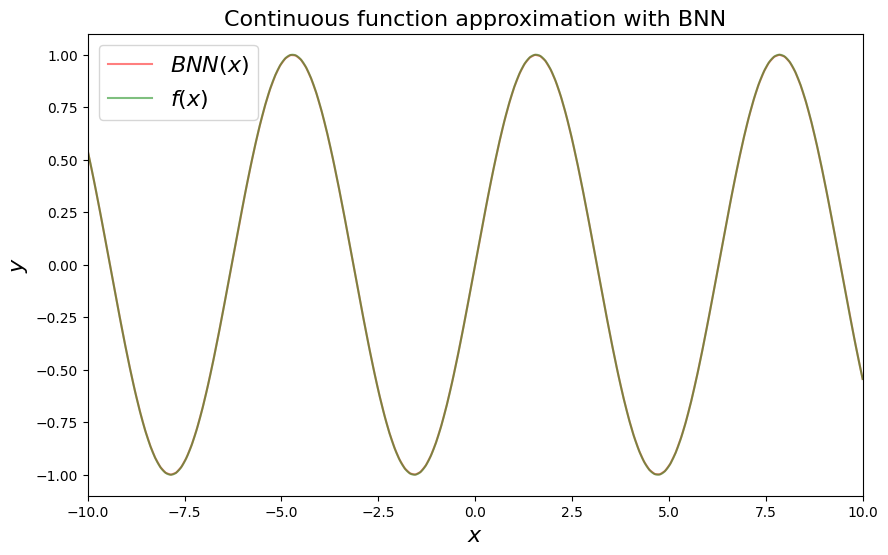

In [2]:
domain =[-10,10]
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), 1000)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

n_segments = 150
x_values = tf.cast(tf.linspace(-10,10,n_segments),dtype=tf.float32)
points = tf.stack([x_values, tf.math.sin(x_values)], axis=1)

model = BaricentricNetworkTf(points)
y_aprox = model(x_train)
    
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_aprox, 'r-', label=f'$BNN(x)$', alpha=0.5)
plt.plot(x_train, y_train, 'g-', label=f'$f(x)$', alpha=0.5)
plt.xlabel('$x$', fontsize=fontsize)
plt.ylabel('$y$', fontsize=fontsize)
plt.xlim((domain[0],domain[1]))
plt.title(f'Continuous function approximation with BNN', fontsize = fontsize)
plt.legend(loc="upper left", fontsize=fontsize)
plt.savefig('figures/BNNApproximationSin_Tensorflow.png', dpi=300, bbox_inches='tight')
plt.show()

# Persistent entropy as a measure of similarity and determination of the number of segments to divide a continuous non-linear function for its approximation.

Let $ f(x) $ be a continuous non-linear function to approximate, and let $ BNN $ be a neural network representing a continuous piecewise linear function (CPLF). For a given desired level of precision $ \epsilon $, there exists a minimum number of segments $ m $ such that the neural network, when dividing $ f(x) $ into $ m $ equidistant segments, approximates $ f(x) $ within the specified precision $ \epsilon $. This minimum number of segments $ m $ is determined through an iterative approach where the number of segments is gradually increased, and the approximation error is evaluated using the persistent entropy metric. Note that the persistent entropy is calculated using the Lower Star filtration for computed the persistent homology, for measure similarity among piecewise linear function and time series.

First, check the similarity using the persistent entropy between the approximation using the barycentric neural network and the objective function, $sin(x)$.

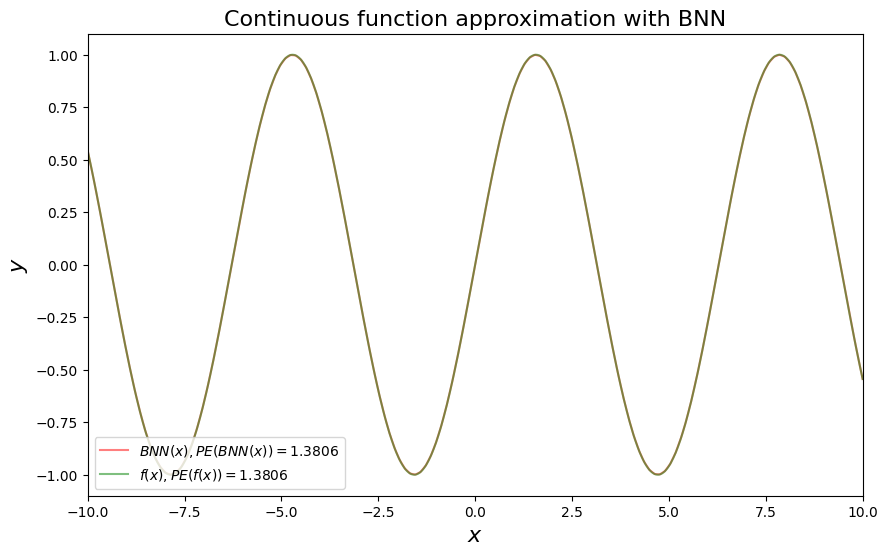

In [3]:
domain =[-10,10]
function=np.sin
n_points=1000
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), n_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(n_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)

n_segments = 150
x_values = tf.cast(tf.linspace(-10,10,n_segments),dtype=tf.float32)
points = tf.stack([x_values, tf.math.sin(x_values)], axis=1)

model = BaricentricNetworkTf(points)
y_aprox = model(x_train)


dgmsRef = layer.call(y_train)
dgmRef = dgmsRef[0][0]
entropyRef=persistent_entropy_tf(dgmRef)

dgmsAprox = layer.call(y_aprox)
dgmAprox = dgmsAprox[0][0]
entropyAprox=persistent_entropy_tf(dgmAprox)

plt.figure(figsize=(10, 6))
plt.plot(x_train, y_aprox, 'r-', label=f'$BNN(x), PE(BNN(x)) = {round(entropyAprox.numpy().item(),4)}$', alpha=0.5)
plt.plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {round(entropyRef.numpy().item(),4)}$', alpha=0.5)
plt.xlabel('$x$', fontsize=fontsize)
plt.ylabel('$y$', fontsize=fontsize)
plt.xlim((domain[0],domain[1]))
plt.title(f'Continuous function approximation with BNN', fontsize = fontsize)
plt.legend(loc="lower left")
plt.savefig('figures/BNNApproximationSinEntropy_Tensorflow.png', dpi=300, bbox_inches='tight')
plt.show()

Then, see an example of how calculating the minimum number of segments m to divide a continuous function to approximate it with a given desired level of precision epsilon. 

Reference Entropy: 1.3805673122406006  



  1%|▉                                                                                 | 11/996 [00:02<03:52,  4.23it/s]

Minimum number of segment required for correct aproximation $\epsilon$ <= 0.001: 16


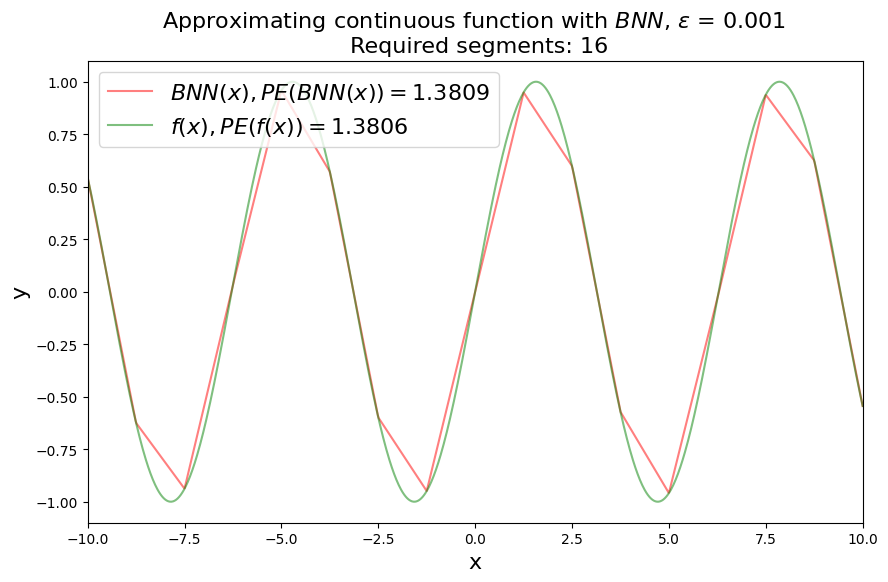

  1%|▉                                                                                 | 11/996 [00:03<04:54,  3.34it/s]


In [4]:
epsilon_threshold = 0.001
min_segments = 5
max_segments = 1000   
domain =[-10,10]
function=np.sin
n_points=1000
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), n_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(n_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)

dgmsRef = layer.call(y_train)
dgmRef = dgmsRef[0][0]
entropyRef=persistent_entropy_tf(dgmRef)
print(f"Reference Entropy: {entropyRef}  \n")

def calculate_entropy_for_approximation(n_segments):
    x_values = tf.cast(tf.linspace(-10,10,n_segments+1),dtype=tf.float32)
    points = tf.stack([x_values, tf.math.sin(x_values)], axis=1)
    
    model = BaricentricNetworkTf(points)
    y_aprox = model(x_train)
    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    entropyAprox=persistent_entropy_tf(dgmAprox)
    return entropyAprox, y_aprox
    

for n_segments in tqdm(range(min_segments, max_segments + 1)):
    entropyModelAprox, y_BNN = calculate_entropy_for_approximation(n_segments)
    error = np.abs(entropyRef-entropyModelAprox)
    if error.item() <= epsilon_threshold:
        print(f"Minimum number of segment required for correct aproximation $\epsilon$ <= {epsilon_threshold}: {n_segments}")
        plt.figure(figsize=(10, 6))
        plt.plot(x_train, y_BNN, 'r-', label=f'$BNN(x), PE(BNN(x)) = {round(entropyModelAprox.numpy().item(),4)}$', alpha=0.5)
        plt.plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {round(entropyRef.numpy().item(),4)}$', alpha=0.5)
        plt.xlabel('x', fontsize=fontsize)
        plt.ylabel('y', fontsize=fontsize)
        plt.xlim((domain[0],domain[1]))
        plt.title(f'Approximating continuous function with $BNN$, $\epsilon$ = {epsilon_threshold} \n Required segments: {n_segments}', fontsize = fontsize)
        plt.legend(loc="upper left", fontsize=fontsize)
        plt.savefig('figures/BNNApproximationSinSegments_Tensorflow.png', dpi=300, bbox_inches='tight')
        plt.show()
        break

## Persistent entropy as a measure of similarity between neural network functions

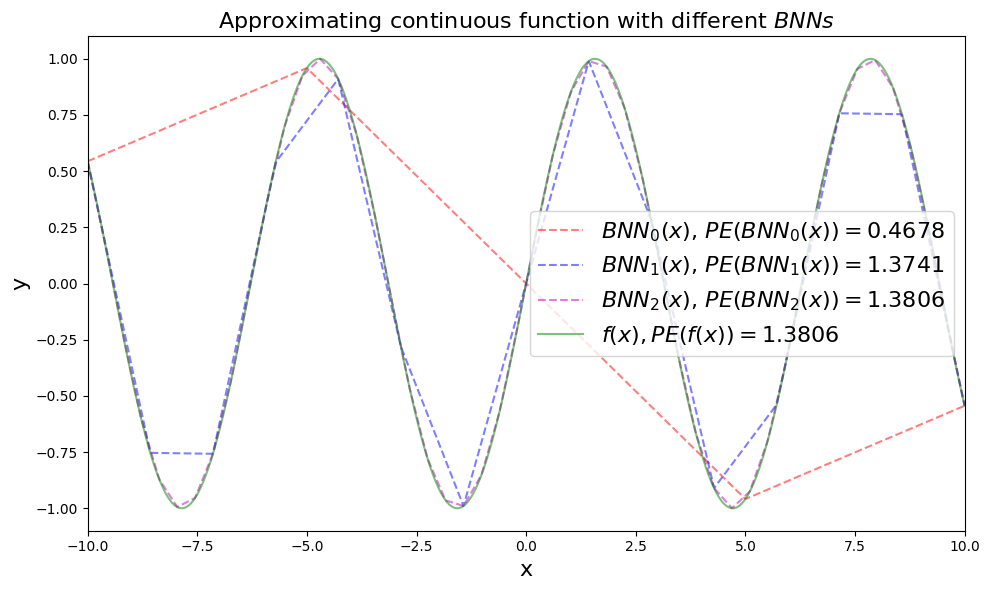

In [5]:
colors = ['r', 'b', 'm']  
entropies = [entropyRef]
plt.figure(figsize=(10, 6))
for idx, n_points in enumerate([5-1, 15-1, 50-1]):
    entropyAprox, y_aprox = calculate_entropy_for_approximation(n_points)
    entropies.append(entropyAprox)
    plt.plot(x_train, y_aprox, f'{colors[idx]}--', 
             label=f'$BNN_{idx}(x)$, $PE(BNN_{idx}(x)) = {round(entropyAprox.numpy().item(),4)}$', alpha=0.5)

plt.plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {round(entropyRef.numpy().item(),4)}$', alpha=0.5)
plt.xlabel('x', fontsize=fontsize)
plt.ylabel('y', fontsize=fontsize)
plt.xlim((domain[0],domain[1]))
plt.title(f'Approximating continuous function with different $BNNs$', fontsize = fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig('figures/BNNApproximationSinSimilarity_Tensorflow.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
n = len(entropies)
difference_matrix = [[round(np.abs(entropies[i] - entropies[j]), 4) for j in range(n)] for i in range(n)]

df = pd.DataFrame(
    difference_matrix,
    columns=[f"Entropy_{i}" for i in ["TargetFunction", "BNN_5points", "BNN_15points", "BNN_50points"]],
    index=[f"Entropy_{i}" for i in ["TargetFunction", "BNN_5points", "BNN_15points", "BNN_50points"]]
)

print(df)

                        Entropy_TargetFunction  Entropy_BNN_5points  \
Entropy_TargetFunction                  0.0000               0.9127   
Entropy_BNN_5points                     0.9127               0.0000   
Entropy_BNN_15points                    0.0065               0.9063   
Entropy_BNN_50points                    0.0000               0.9128   

                        Entropy_BNN_15points  Entropy_BNN_50points  
Entropy_TargetFunction                0.0065                0.0000  
Entropy_BNN_5points                   0.9063                0.9128  
Entropy_BNN_15points                  0.0000                0.0065  
Entropy_BNN_50points                  0.0065                0.0000  
